## Get prediction

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import numpy as np
import torch
import cv2

sys.path.insert(0, '..')
from isegm.ritm.utils import vis, exp

from isegm.inference import utils
from isegm.simple_click.inference.evaluation import evaluate_sample
from isegm.simple_click.inference.predictors import get_predictor
from isegm.simple_click.model.is_plainvit_model import PlainVitModel
from isegm.simple_click.model.modeling.transformer_helper.cross_entropy_loss import CrossEntropyLoss
from isegm.data.preprocess import Preprocessor
from isegm.simple_click.model.modeling.pos_embed import interpolate_pos_embed_inference

device = torch.device('cuda:0')
cfg = exp.load_config_file('config.yml', return_edict=True)

In [87]:
# xTiny

backbone_params = dict(
    img_size=(448, 448),
    # img_size=(512,512),
    patch_size=(16, 16),
    in_chans=3,
    embed_dim=160,
    depth=8,
    num_heads=4,
    mlp_ratio=4,
    qkv_bias=True,
)

neck_params = dict(
    in_dim=160,
    out_dims=[96, 192, 288, 384],
)

head_params = dict(
    in_channels=[96, 192, 288, 384],
    in_index=[0, 1, 2, 3],
    dropout_ratio=0.1,
    num_classes=1,
    loss_decode=CrossEntropyLoss(),
    align_corners=False,
    # upsample=cfg.upsample,
    upsample='x1',
    channels=128,
)

In [153]:
EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.49

TRAINING_OUTPUT_PATH = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training'
PRETRAINED_WEIGTHS_PATH = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/weights'

checkpoint_path = f'{PRETRAINED_WEIGTHS_PATH}/sbd_vit_xtiny.pth'

train_config = {'model_path':'models/simpleclick/plainvit_xtiny448_3c_model.py'}

model = utils.load_is_model(checkpoint_path, 'cpu', train_config=train_config)

print(model.backbone.patch_embed.num_patches)

model_class: <class 'isegm.simple_click.model.is_plainvit_model.PlainVitModel'>
784


In [156]:
model = model.to(device)

In [157]:
# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
# brs_mode = 'NoBRS'
brs_mode = 'NoBRS'

zoom_in_params = None
# zoom_in_params['skip_clicks'] = 0

# interpolate_pos_embed_inference(model.backbone, backbone_params['img_size'], device)

predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH, zoom_in_params=zoom_in_params) 

NoBRS
True


In [158]:
# Possible choices: 'DAVIS', 'BRATS', 'LIDC', 'LIDC_2D_VAL', 'LIDC_2D_256_VAL', 'LIDC_CROPS_BOXED', 'LIDC_CROPS_WHITENED', 'LIDC_CROPS'
DATASET = 'LIDC_2D_VAL'
preprocessor = Preprocessor()
preprocessor.normalize = True
preprocessor.windowing = True
preprocessor.convert_to_rgb = True
preprocessor.window_min = -900
preprocessor.window_max = 600
# preprocessor.convert_to_rgb = True

dataset = utils.get_dataset(DATASET, cfg, preprocessor=preprocessor)

In [159]:
predictor

In [160]:
sample_id = 3 # 28
TARGET_IOU = 1

use_init_mask = False

sample = dataset.get_sample(sample_id)

gt_mask = sample.gt_mask
image = sample.image

# print(image.shape)

# # image = torch.nn.functional.interpolate(
# #                 torch.unsqueeze(torch.tensor(image), 0),
# #                 size=(backbone_params['img_size'][0], backbone_params['img_size'][1]),
# #                 mode='bilinear',
# #                 align_corners=True,
# #             ).squeeze().numpy()

# print(image.shape)

# image = image[:448, :448]
# gt_mask = gt_mask[:448, :448]

init_mask = np.zeros_like(gt_mask)

if use_init_mask and sample.init_mask is not None:
    init_mask = sample.init_mask


clicks_list, ious_arr, pred = evaluate_sample(image, gt_mask, predictor, 
                                              pred_thr=MODEL_THRESH, 
                                              max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS)

# pred_mask = pred_list[-1] > MODEL_THRESH
# draw = vis.draw_with_blend_and_clicks(image, mask=pred_mask, clicks_list=clicks_list)
# draw = np.concatenate((draw,
#     255 * pred_mask[:, :, np.newaxis].repeat(3, axis=2),
#     255 * (gt_mask > 0)[:, :, np.newaxis].repeat(3, axis=2)
# ), axis=1)
print(np.round(ious_arr, 3))
# plt.figure(figsize=(12, 18))
# plt.imshow(draw)
# plt.show()
plt.imshow(pred > MODEL_THRESH)

RuntimeError: The size of tensor a (1024) must match the size of tensor b (784) at non-singleton dimension 1

# Visualise progression graph:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import base64

def show_animation(animation):
    html = animation.to_jshtml()
    
    return HTML(html)

def show_animation_from_file(filename):
    
    with open(filename, 'rb') as f:
        gif_data = f.read()

    gif_base64 = base64.b64encode(gif_data).decode('utf-8')

    html_code = f'<img src="data:image/gif;base64,{gif_base64}">'
    return HTML(html_code)

def save_animation(animation, filename):
    animation.save(f'{filename}.gif', writer='pillow')

def generate_click_animation(image, gt_mask, iou_values, clicks, predictions):
    fig, ax = plt.subplots(1, 3, figsize=(24, 8))
        
    iou_values = np.append(np.array([0]), iou_values)
    
    num_frames = len([iou_val for iou_val in iou_values if not np.isnan(iou_val)])
        
    ax[0].imshow(image, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Clicks: 0', fontsize=20)
    ax[0].contour(gt_mask, colors='b', alpha=0.5, linewidths=0.1)
    
    ax[1].axis('off')
    ax[1].imshow(image, cmap='gray')
    ax[1].set_title(f'IOU: {0.}', fontsize=20)
    
    ax[2].set_xticks(np.arange(1, len(iou_values)+1))
    ax[2].set_ylim(0, 1.05)
    ax[2].set_xlabel('Clicks')
    ax[2].set_ylabel('IOU')
    ax[2].set_title('IOU after each click', fontsize=20)
    
    plt.close()
    
    def update(frame_index):
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title(f'Clicks: {frame_index}', fontsize=20)
        ax[0].contour(gt_mask, colors='b', alpha=0.5, linewidths=0.1)
        for click in clicks[:frame_index]:
            color = 'lime' if click.is_positive else 'r'
            y, x = click.coords
            ax[0].scatter(x, y, s=20, c=color)
        
        ax[1].imshow(image, cmap='gray')
        if (frame_index > 0):
            prediction_masked = np.ma.masked_where(predictions[frame_index-1] == 0, predictions[frame_index-1])
            ax[1].imshow(prediction_masked, alpha=0.5, cmap='gist_rainbow')
            ax[1].set_title(f'IOU: {iou_values[frame_index]:.3f}', fontsize=20)
            
        ax[2].plot(np.arange(frame_index + 1), iou_values[:frame_index + 1], color='b')
        
        return
    
    animation = FuncAnimation(fig, update, frames=num_frames, interval=1000, blit=False)
    return animation

anim = generate_click_animation(image[:, :, 0], gt_mask, ious_arr, clicks_list, pred_list)
show_animation(anim)

## Visualise each part

In [56]:
step_info = info_list[0]

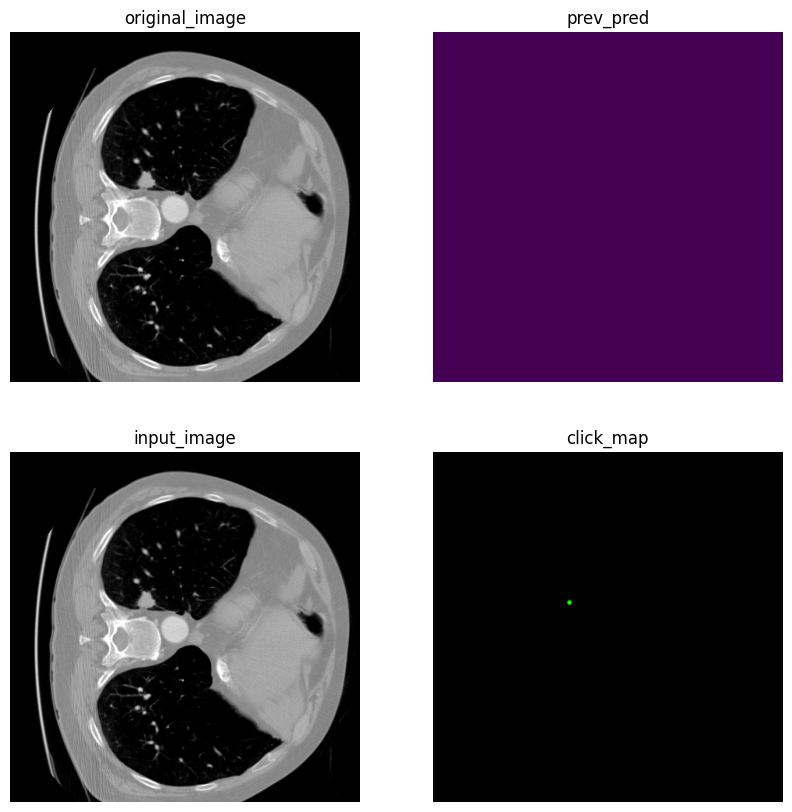

In [57]:
def show_before_coarse(info):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    plt.close()
    
    ax[0,0].set_title('original_image')
    ax[0,0].imshow(info['original_image'][0], cmap='gray')
    ax[0,0].axis('off')
    
    ax[0,1].set_title('prev_pred')
    ax[0,1].imshow(info['prev_mask'])
    ax[0,1].axis('off')
    
    ax[1,0].set_title(f'input_image')
    ax[1,0].imshow(info['image_transforms']['image_nd'].cpu()[0, 0], cmap='gray')
    ax[1,0].axis('off')
    
    ax[1,1].set_title('click_map')
    ax[1,1].imshow(info['image_transforms']['image_nd'].cpu()[0, 3], cmap='gray')
    ax[1,1].axis('off')
    y = [click.coords[0] for click in info['image_transforms']['clicks_lists'][0]]
    x = [click.coords[1] for click in info['image_transforms']['clicks_lists'][0]]
    c = [click.is_positive for click in info['image_transforms']['clicks_lists'][0]]
    c = ['lime' if i else 'red' for i in c]
    ax[1,1].scatter(x, y, c=c, s=5)
    
    return fig

show_before_coarse(step_info)

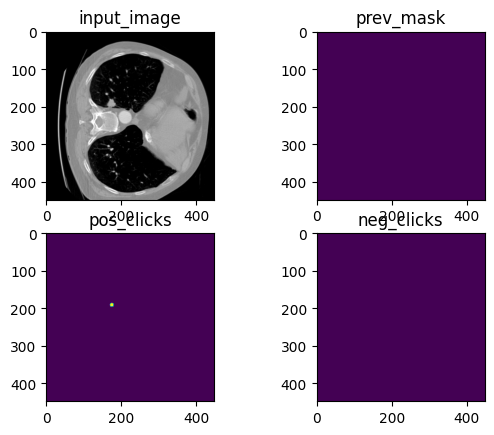

In [58]:
def show_coarse_input(info):
    
    info = info['coarse_seg']
    
    fig, ax = plt.subplots(2, 2)
    plt.close()
    
    ax[0, 0].set_title('input_image')
    ax[0, 0].imshow(info['prepared_input']['image'].cpu()[0, 0], cmap='gray')
    
    ax[0, 1].set_title('prev_mask')
    ax[0, 1].imshow(info['prepared_input']['prev_mask'].cpu()[0, 0])
    
    ax[1, 0].set_title('pos_clicks')
    ax[1, 0].imshow(info['click_map'].cpu()[0, 0])
    
    ax[1, 1].set_title('neg_clicks')
    ax[1, 1].imshow(info['click_map'].cpu()[0, 1])
    
    return fig

show_coarse_input(step_info)

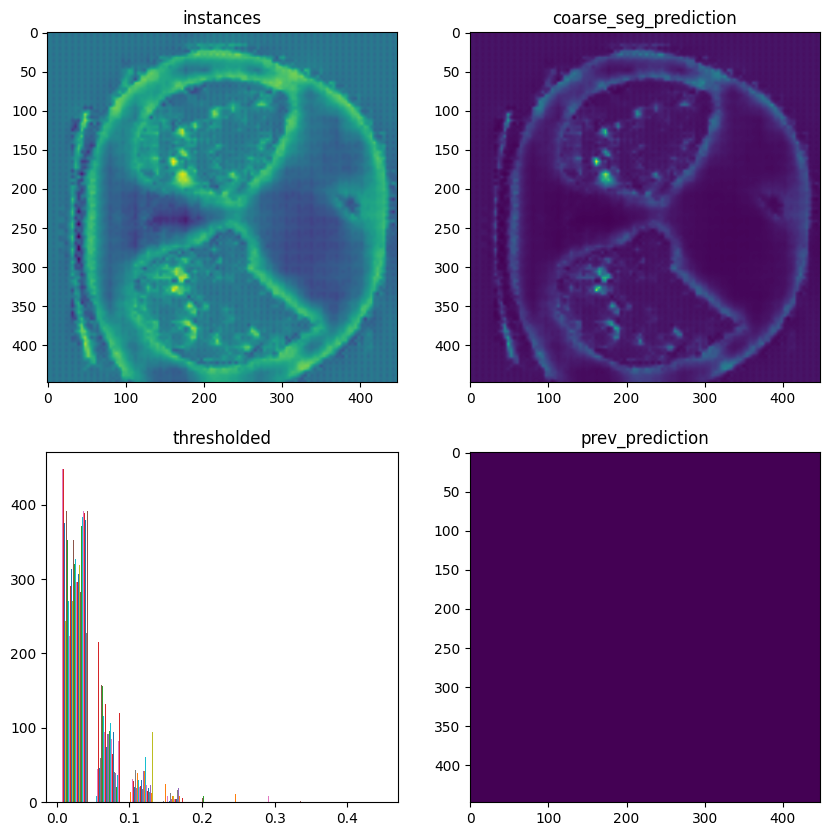

In [59]:
def show_coarse_predictions(info):

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    plt.close()
    
    ax[0, 0].set_title('instances')
    ax[0, 0].imshow(info['coarse_seg']['outputs']['instances'].cpu()[0, 0])
    
    ax[0, 1].set_title('coarse_seg_prediction')
    new_mask = torch.sigmoid(info['coarse_seg']['outputs']['instances'].cpu()[0, 0]).numpy()
    ax[0, 1].imshow(new_mask)
    
    ax[1, 0].set_title('thresholded')
    ax[1, 0].hist(new_mask)
    
    ax[1,1].set_title('prev_prediction')
    ax[1,1].imshow(info['coarse_seg']['prepared_input']['prev_mask'].cpu()[0, 0])
    
    return fig

show_coarse_predictions(step_info)

## Animation code

In [10]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import base64

def show_animation(animation):
    html = animation.to_jshtml()
    
    return HTML(html)

def show_animation_from_file(filename):
    
    with open(filename, 'rb') as f:
        gif_data = f.read()

    gif_base64 = base64.b64encode(gif_data).decode('utf-8')

    html_code = f'<img src="data:image/gif;base64,{gif_base64}">'
    return HTML(html_code)

def save_animation(animation, filename):
    animation.save(f'{filename}.gif', writer='pillow')
    
def generate_click_animation(image, gt_mask, iou_values, clicks, predictions, info_list):
    fig, ax = plt.subplots(2, 3, figsize=(9, 7))
    if len(image.shape) == 3:
        image = image[:, :, 0]
        
    num_frames = len(clicks)
        
    ax[0,0].imshow(image, cmap='gray')
    ax[0,0].axis('off')
    ax[0,0].set_title('Image, gt mask,\nClicks', fontsize=20)
    ax[0,0].contour(gt_mask, colors='b', alpha=0.5, linewidths=0.1)

    ax[1, 1].set_title('Coarse logits')
    
    plt.close()
    
    def update(frame_index):
        
        fig.suptitle(f'Click {frame_index + 1}', fontsize=20)
        
        ax[0,0].imshow(image, cmap='gray')
        ax[0,0].set_title(f'Clicks: {frame_index + 1}', fontsize=20)
        ax[0,0].contour(gt_mask, colors='b', alpha=0.5, linewidths=0.1)
        for click in clicks[:frame_index + 1]:
            color = 'lime' if click.is_positive else 'r'
            y, x = click.coords
            ax[0,0].scatter(x, y, s=10, c=color)
            
        ax[0,1].clear()
        ax[0,1].set_title('Previous predicition', fontsize=20)
        ax[0,1].axis('off')
        ax[0,1].imshow(info_list[frame_index]['prev_mask'])
        
        ax[0,2].clear()
        ax[0,2].axis('off')
        ax[0,2].set_title(f'Input image', fontsize=20)
        ax[0,2].imshow(info_list[frame_index]['image_transforms']['image_nd'].cpu()[0, 0], cmap='gray')
        
        image_transforms = info_list[frame_index]['image_transforms']
        ax[1,0].clear()
        ax[1,0].set_title('Click map', fontsize=20)
        ax[1,0].axis('off')
        ax[1,0].imshow(image_transforms['image_nd'].cpu()[0, 3], cmap='gray')
        
        # start_y, end_y, start_x, end_x = info_list[frame_index]['global_roi']
        # cur_clicks = image_transforms['clicks_lists'][0]
        # y = [click.coords[0] for click in image_transforms['clicks_lists'][0]]
        # x = [click.coords[1] for click in image_transforms['clicks_lists'][0]]
        # c = [click.is_positive for click in image_transforms['clicks_lists'][0]]
        # c = ['lime' if i else 'red' for i in c]
        # ax[1,0].scatter(x, y, c=c, s=20)
        
        ax[1,1].clear()
        ax[1,1].set_title('Coarse prediction', fontsize=20)
        ax[1,1].axis('off')
        ax[1,1].imshow(info_list[frame_index]['coarse_seg_prediction'])
        
        ax[1,2].clear()
        ax[1,2].axis('off')
        ax[1,2].set_title(f'Final prediction', fontsize=20)
        ax[1,2].imshow(predictions[frame_index])
        
        return
    
    animation = FuncAnimation(fig, update, frames=num_frames, interval=1000, blit=False)
    return animation

In [11]:
anim = generate_click_animation(image, gt_mask, ious_arr, clicks_list, pred_list, info_list)
show_animation(anim)